# CI width by changing sample size for QMC and IID Beta

The paper takes $X_1, X_2, \ldots \stackrel{\text{IID}}{\sim} F$ and computes a sequential confidence interval for $\mu = \mathbb{E}(X)$.

For QMC, we are going to take 

$$
X_i = \frac{1}{m} \sum_{j=1}^m T_{ij},
$$ 

where for each $i$, $\{T_{ij}\}_{j=1}^m$ is a QMC set that mimics $F$. Therefore, $X_i$ is close to $\mu$, and the sequence $\{X_i\}_{i=1}^n$ is an IID sequence based on $mn$ samples.

In this notebook, $F$ is a Beta Distribution and DigitalNetB2 (Sobol) has been used for QMC.

Importing the modules:

In [49]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
from scipy.stats import beta
from scipy.stats import multinomial
import matplotlib.cm as cm

sys.path.append(os.path.relpath("../.."))
from confseq.cs_plots import ConfseqToPlot, DataGeneratingProcess, plot_CSs
from other_bounds import hoeffding_ci, maurer_pontil_empbern_ci
from confseq.predmix import predmix_empbern_ci_seq
from confseq.betting import betting_ci_seq

figures_location = os.path.relpath("figures/")

import random
import qmcpy as qp

%matplotlib inline

## IID vs QMC_IID (IID replications through spawning)

Plot for IID_Beta

IID mean =  0.2509387662541594
IID std =  0.0011964038085364014
Using 11 cores


/opt/miniconda3/envs/bet_sim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57
/opt/miniconda3/envs/bet_sim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57
/opt/miniconda3/envs/bet_sim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57
/opt/miniconda3/envs/bet_sim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57
/opt/miniconda3/envs/bet_sim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57
/opt/miniconda3/envs/bet_sim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57


CI width at sample size N =  0.007000000000000006
Using 11 cores


/opt/miniconda3/envs/bet_sim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57
/opt/miniconda3/envs/bet_sim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57
/opt/miniconda3/envs/bet_sim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57
/opt/miniconda3/envs/bet_sim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57
/opt/miniconda3/envs/bet_sim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57
/opt/miniconda3/envs/bet_sim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57


Hedged-CI [Rmk 3] took an average of 0.6694529056549072 seconds
Hedged-CI [Rmk 3] miscovered in 0 out of 1 experiments


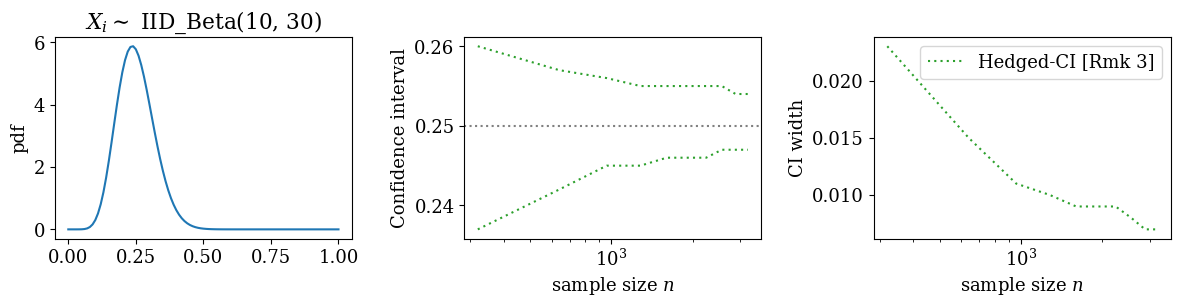

In [50]:
N = 100 * (2**5) # The sample size
alpha = 0.05
times = (10 * (np.arange(1,11))) * (2**5) # The times (sample sizes) for which we'll use the lower and upper bound values

# The Hedged CI
cs_list = [
    ConfseqToPlot(
        lambda x: betting_ci_seq(
            x, times=times, alpha=alpha, parallel=True, m_trunc=True, trunc_scale=3 / 4
        ),
        "Hedged-CI [Rmk 3]",
        "tab:green",
        ":",
  
    ),
]

# The IID_Beta generator
dgp_list_iid = [

    DataGeneratingProcess(
        data_generator_fn=lambda: np.random.beta(10, 30, N),
        name="Beta_10,_30_",
        dist_fn=lambda x: beta.pdf(x, 10, 30),
        mean=1 / 4,
        discrete=False,
        title="$X_i \sim$ IID_Beta(10, 30)",
    ),
]

# Printing out the mean, std, and last CI width (CI width at sample size N)
x_iid = dgp_list_iid[0].data_generator_fn() 
print("IID mean = ", x_iid.mean())
print("IID std = ", x_iid.std()/np.sqrt(N))
lower_bound,upper_bound = betting_ci_seq(x_iid, times=times, alpha=alpha, parallel=True, m_trunc=True, trunc_scale=3 / 4)
print("CI width at sample size N = ", upper_bound[len(upper_bound) - 1] - lower_bound[len(lower_bound) - 1])

# The plotting function
plot_CSs(
    dgp_list_iid,
    cs_list,
    times=times,
    time_uniform=False,
    display_start=1,
    nsim=1,
    log_scale=True,
    folder=figures_location,
)


Plot for IID_QMC_Beta:

QMC mean =  0.24999892301082444
QMC std =  0.0001354707865896501
Using 11 cores
CI width at sample size spawn_samples =  0.05200000000000002
Using 11 cores
Hedged-CI [Rmk 3] took an average of 0.251384973526001 seconds
Hedged-CI [Rmk 3] miscovered in 0 out of 1 experiments


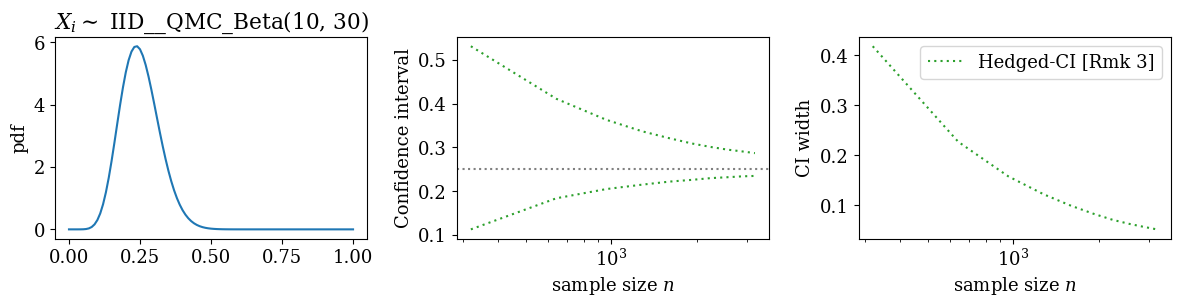

In [51]:
# The function to generate the IID_QMC_Beta samples
def gen_qmc_samples_iid(distribution = qp.SciPyWrapper(discrete_distrib=qp.DigitalNetB2(1,seed = 7),scipy_distribs=beta(a=10,b=30))
                         , spawn_samples = 11 ,gen_samples = 2**8):
    spw = distribution
    spws = spw.spawn(spawn_samples)
    samples = spws[0].gen_samples(gen_samples).flatten()
    for i in range (len(spws)- 1):
        curr_samples = spws[i + 1].gen_samples(gen_samples).flatten()
        samples = np.vstack((samples,curr_samples))
    return np.mean(samples, axis = 1)

spawn_samples = 100 # The number of IID replications
gen_samples = 2**5 # The number of samples generated per replication
alpha = 0.05
times = 10 * np.arange(1,11) # The times (sample sizes) for which we'll use the lower and upper bound values

cs_list = [
    ConfseqToPlot(
        lambda x: betting_ci_seq(
            x, times=times, alpha=alpha, parallel=True, m_trunc=True, trunc_scale=3 / 4
        ),
        "Hedged-CI [Rmk 3]",
        "tab:green",
        ":",
  
    ),
]

# The Hedged CI
dgp_list_qmc = [

    DataGeneratingProcess(
        data_generator_fn=lambda: gen_qmc_samples_iid(spawn_samples=spawn_samples,gen_samples=gen_samples),
        name="QMC_Beta_10,_30_",
        dist_fn=lambda x: beta.pdf(x, 10, 30),
        mean=1 / 4,
        discrete=False,
        title="$X_i \sim$ IID__QMC_Beta(10, 30)",
    ),
]

# Printing out the mean, std, and last CI width (CI width at sample size spawn_samples)
x_qmc = dgp_list_qmc[0].data_generator_fn()
print("QMC mean = ", x_qmc.mean())
print("QMC std = ", x_qmc.std()/np.sqrt(spawn_samples))
lower_bound,upper_bound = betting_ci_seq(x_qmc, times=times, alpha=alpha, parallel=True, m_trunc=True, trunc_scale=3 / 4)
print("CI width at sample size spawn_samples = ", upper_bound[len(upper_bound) - 1] - lower_bound[len(lower_bound) - 1])

plot_CSs(
    dgp_list_qmc,
    cs_list,
    times=times * gen_samples,
    time_uniform=False,
    display_start=1,
    nsim=1,
    log_scale=True,
    folder=figures_location,
)
